In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO
from backtesting import Backtest, Strategy
import backtesting
from tabulate import tabulate
backtesting.set_bokeh_output(notebook=False)

In [27]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
sma_window = 20
std = 2

In [33]:
from_symbol = "EUR"
to_symbol = "JPY"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

In [38]:
# Load the monthly data from the API
monthly_url = f"https://www.alphavantage.co/query?function=FX_MONTHLY&from_symbol={from_symbol}&to_symbol={to_symbol}&apikey={api_key}&datatype=csv"
monthly_request = requests.get(monthly_url)

#Convert the CSV to a pandas dataframe
monthly_data = StringIO(monthly_request.text)
csv_res_monthly_df = pd.read_csv(monthly_data)

# Convert to DataFrame
monthly_data_df = csv_res_monthly_df.copy()
monthly_data_df['timestamp'] = pd.to_datetime(monthly_data_df['timestamp'])
monthly_pricing_df = monthly_data_df.set_index('timestamp')
monthly_pricing_df.sort_index(ascending=True, inplace=True)

In [39]:
#Seperate the data into two sets:
backtest_dataset = pd.DataFrame(monthly_pricing_df.loc['2005-01-01' : '2013-12-31'].copy())
rerun_dataset = pd.DataFrame(monthly_pricing_df.loc['2014-01-01':'2022-12-31'].copy())

backtest_dataset = backtest_dataset.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close'})

In [40]:
def indicator(data, sma_window, std):
    bbands = ta.bbands(close = data.Close.s, length = sma_window, std = std)
    return bbands.to_numpy().T[:3]

class BollingerBandsStrategy(Strategy):
    
    std_cust = std
    sma_window_cust = sma_window
    
    def init(self):
        self. bbands = self.I(indicator, self.data, self.std_cust, self.sma_window_cust)

    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
                self.position.sell()
        else:
            if self.data.Close[-1] > lower_band[-1]:
                self.position.close()
                self.buy()

In [41]:
bt = Backtest(backtest_dataset, BollingerBandsStrategy, cash=10000, commission=0.01)
stats = bt.run()

In [42]:
optimized_stats, heatmap = bt.optimize(
    sma_window_cust = range(20, 50, 5),
    std_cust = range(2, 10, 1),
    maximize = "Equity Final [$]",
    return_heatmap = True
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [43]:
heatmap

sma_window_cust  std_cust
20               2            9928.3823
                 3           10225.7087
                 4           10329.6996
                 5           10277.3197
                 6           10112.8096
                 7           10098.9928
                 8           10108.4464
                 9            9880.6080
25               2            9928.3823
                 3           10225.7087
                 4           10329.6996
                 5           10277.3197
                 6           10112.8096
                 7           10098.9928
                 8           10108.4464
                 9            9880.6080
30               2            9928.3823
                 3           10225.7087
                 4           10329.6996
                 5           10277.3197
                 6           10112.8096
                 7           10098.9928
                 8           10108.4464
                 9            9880.6080
35            

In [46]:
hm = heatmap.groupby(['sma_window_cust', 'std_cust']).mean().unstack()
hm

std_cust,2,3,4,5,6,7,8,9
sma_window_cust,,,,,,,,
20,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608
25,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608
30,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608
35,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608
40,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608
45,9928.3823,10225.7087,10329.6996,10277.3197,10112.8096,10098.9928,10108.4464,9880.608


<Axes: xlabel='std_cust', ylabel='sma_window_cust'>

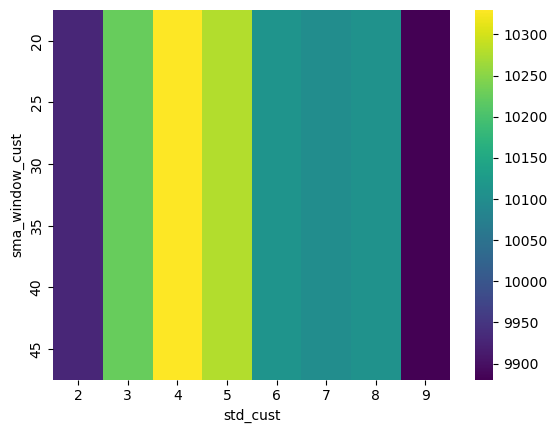

In [49]:
sns.heatmap(hm, cmap='viridis')

<Axes: xlabel='std_cust', ylabel='sma_window_cust'>

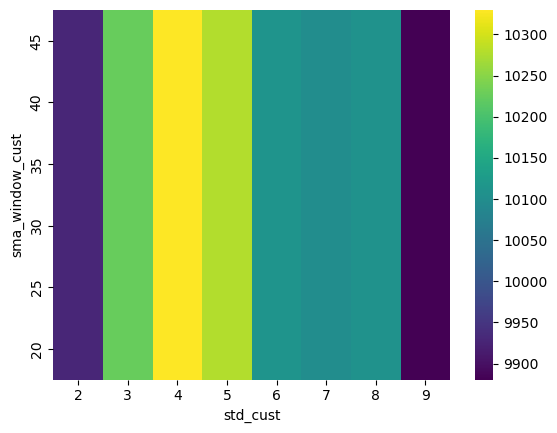

In [50]:
sns.heatmap(hm[::-1], cmap='viridis')